In [1]:
!pip install pandas natasha pymystem3 ipymarkup nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=a66f752f3f183251bec771092f0509d680cd7d3e15e07010f70316b32d5877d2
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b2fe90943e3a1d681764ec19c230022808aed5e743c3705f06da4982c6c88b32
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built intervaltree docopt


In [2]:
import pandas as pd
import pymystem3
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)
from ipymarkup import show_dep_ascii_markup as show_markup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Загружаем данные
df = pd.read_csv('statyi.csv', sep='\t')

# Удаляем лишние столбцы
morph_df = df.drop(["Unnamed: 0", "created_date"], axis=1)
morph_df

,title,content,category
0,Климкин рассказал о главных достижениях Украин...,Министр иностранных дел Украины Павел Климкин ...,Бывший СССР
1,В России запретили алкогольные энергетики,В России с 1 января 2018 года запрещаются прои...,Россия
2,Полиция Берлина сообщила о случаях сексуальных...,Полиция Берлина заявила об имевших место сексу...,Мир
3,МЧС отчиталось о первых часах наступившего года,Чрезвычайных ситуаций во время время празднова...,Россия
4,Обнаружено неожиданное средство от старения мозга,Ученые Ланкастерского университета в Великобри...,Наука и техника
...,...,...,...
9995,Стали известны сроки появления российской базы...,Российскую базу на Луне планируется развернуть...,Наука и техника
9996,На Аляске произошло мощное землетрясение,"Землетрясение магнитудой 7,0 произошло в пятни...",Мир
9997,Названо главное блюдо мировых лидеров на самми...,Главным блюдом на ужине в первый день саммита ...,Мир
9998,Анджелина Джоли и Брэд Питт договорились об оп...,Голливудские актеры Анджелина Джоли и Брэд Пит...,Из жизни


# Нормализация и векторизация данных

### Токенизация

In [4]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

#Хранилище токенов к каждому предложению
sent_tokens = []

for article in morph_df['content']:
    doc = Doc(article)
    doc.segment(segmenter)
    doc.parse_syntax(syntax_parser)
    doc.tag_morph(morph_tagger)
    for sentence in doc.sents: # получаем предложения
        # При принте синтаксиса вылетает ошибка "max() iterable argument is empty"
        #sentence.syntax.print()
        sent_tokens.append([])
        for token in sentence.tokens: # получаем токены
            #print(token)
            sent_tokens[-1].append(token)



In [5]:
#Чистим датасет от ненужных данных

nltk.download(['averaged_perceptron_tagger_ru', 'stopwords', 'punkt'])

STOP_LIST = nltk.corpus.stopwords.words('russian')

punkt_list = [".", ",", "!", "?", "...", ":", ";", "это", "слово", "который"
              "из", "на", "под", "ранее"]

lemma = []

mystem=pymystem3.Mystem()

for x in range(len(sent_tokens)):
    lemma.append([])
    for y in range(len(sent_tokens[x])):
        lemma[-1].append(mystem.lemmatize(sent_tokens[x][y].text))


for simb in punkt_list:
  STOP_LIST.append(simb)

lemma_words = {
    'word' : []
}

for sent in lemma:
  for word in sent:
    if word[0] not in STOP_LIST:
      #убираем числа
      try:
        if isinstance(int(word[0]), int):
          pass
      except ValueError:
          lemma_words['word'].append(word[0])

lemma_df = pd.DataFrame(lemma_words)

lemma_df

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


,word
0,министр
1,иностранный
2,дело
3,украина
4,павел
...,...
1383713,суэцкий
1383714,канал
1383715,северный
1383716,морской


In [6]:
# Делаем датафрейм для последующей кластеризации

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lemma_df['word'].head(10000))

#Сжатие
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

X_pca


array([[-0.01520776, -0.00543113],
       [-0.01489694, -0.00514004],
       [-0.01531427, -0.00553604],
       ...,
       [-0.01479613, -0.00504973],
       [-0.01479613, -0.00504973],
       [-0.01459856, -0.00487824]])

# Кластеризация

In [7]:

dbscan = DBSCAN(eps=0.5, min_samples=2)
clusters = dbscan.fit_predict(X_pca)

data = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'cluster': clusters})



# Визуализация кластеров

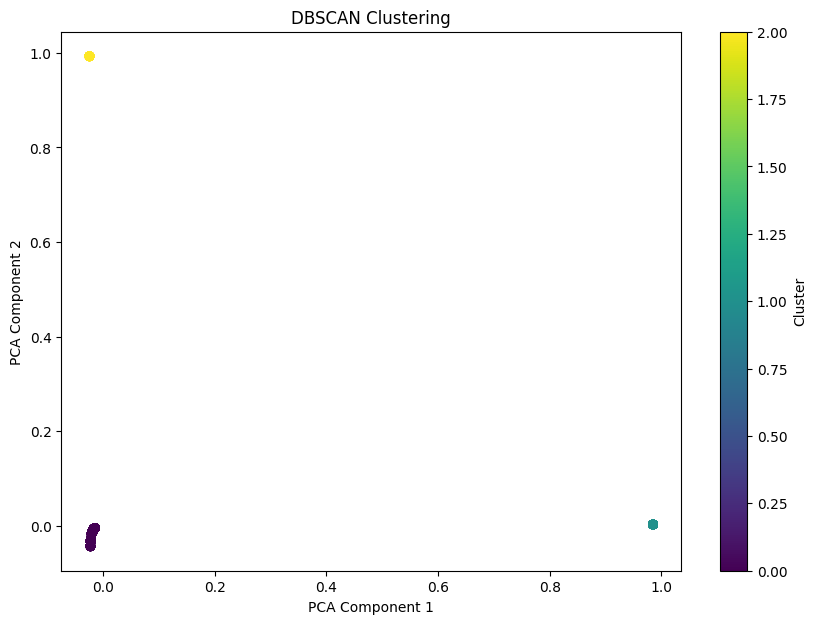

In [8]:
plt.figure(figsize=(10, 7))
plt.scatter(data['x'], data['y'], c=data['cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [9]:
# Выделение слов по кластерам
for cluster in set(clusters):
    print(f"Cluster {cluster}:")
    cluster_texts = [lemma_df['word'][i] for i in range(len(clusters)) if clusters[i] == cluster]
    print(cluster_texts)

Cluster 0:
['министр', 'иностранный', 'дело', 'украина', 'павел', 'климкин', 'записывать', 'видеообращение', ',\n', 'который', 'перечислять', 'главный', 'достижение', 'украина', 'видео', 'доступно', 'YouTube', 'достижение', 'причислять', 'введение', 'безвизовый', 'режим', 'европейский', 'союз', 'освобождение', 'украинский', 'военнопленный', 'зона', 'вооруженный', 'конфликт', 'донбасс', 'отмечать', ',\n', 'полный', '«\n', 'позитивный', 'чувство', '»\n', '«\n', 'особый', 'эмоция', ',\n', 'число', 'очень', 'положительный', 'эмоция', 'вспоминать', 'лицо', 'украинец', ',\n', 'который', 'июнь', 'первый', 'пересекать', 'граница', 'европейский', 'союз', 'безвиза', '»\n', ',\n', '—\n', 'рассказывать', '«\n', 'нужно', 'положительный', 'эмоция', 'нужно', 'драйв', 'будущее', '»\n', ',\n', '—\n', 'добавлять', 'климкин', 'декабрь', 'свой', 'мнение', 'главное', 'достижение', 'украина', 'поделиться', 'президент', 'страна', 'петр', 'порошенко', '«\n', 'июнь', 'каждый', 'украинец', ',\n', 'который', 'по

Второй и третий кластеры состоят из множества копий одного слова: третий = "сообщать", второй = "год". В первый кластер вошли все оставшиеся слова